In [43]:
import os
import yaml
import torch
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from torch.optim import Adam
from diffusion import NoiseScheduler, unet
from autoencoder_cnn import increasingLoss
from torch.utils.data.dataset import Dataset
import torch.optim.lr_scheduler as lr_scheduler
from autoencoder_cnn import autoencoder, send_webHook

In [44]:
encoder = torchvision.models.vgg16(pretrained=False) # autoencoder shape
encoder = encoder.features[:11]

/home/maiku/Desktop/DMAD-DDPM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maiku/Desktop/DMAD-DDPM/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [45]:
BATCH_SIZE = None
EPOCHS = None
URL = None
OUTPUT_PATH = None
BONAFIDE_PATH = None
MORPHS_PATH = None
AUTOENCODER_PATH = None
PRETRAINED_PATH = None
LEARNING_RATE = None
STARTING_CHECKPOINT = None

FREEZE_ENCODER = None
NOISE_COEFFICIENT = None

DOWN_BLOCKS = None
MIDDLE_BLOCKS = None
UP_BLOCKS = None
DOWN_SAMPLE = None
device = None

In [46]:
configFile = "conf.yaml"

conf = yaml.safe_load(Path(configFile).read_text())

In [47]:
BATCH_SIZE = conf['diffusion']['batch_size']
EPOCHS = conf['diffusion']['epochs']
URL = conf['diffusion']['webhook']
OUTPUT_PATH = conf['diffusion']['output_path']
BONAFIDE_PATH = conf['diffusion']['bonafide_path']
MORPHS_PATH = conf['diffusion']['morphs_path']
AUTOENCODER_PATH = conf['diffusion']['model_input']
STEPS = conf['diffusion']['forward_steps']
STARTING_CHECKPOINT = conf['diffusion']['starting_checkpoint']
LEARNING_RATE = conf['diffusion']['learning_rate']
NOISE_COEFFICIENT = conf['diffusion']['noise_coefficient']

DOWN_BLOCKS = conf['diffusion']['unet']['down_block']
MIDDLE_BLOCKS = conf['diffusion']['unet']['middle_block']
UP_BLOCKS = conf['diffusion']['unet']['up_block']
DOWN_SAMPLE = conf['diffusion']['unet']['down_sample']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")



using device: cuda


In [48]:
ae = autoencoder(encoder)
ae.load_state_dict(torch.load(AUTOENCODER_PATH))
AUTOENCODER_PATH

'out_ae_reduced_x4/ae_Casia_30.pth'

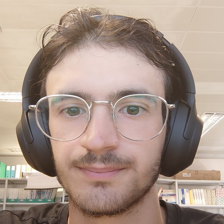

In [49]:
img = Image.open('../not_me.png').convert("RGB")
img = img.resize([224, 224])

img



In [50]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(data_range=1).to(device)
mse = nn.MSELoss().to(device)

In [51]:
img = torchvision.transforms.ToTensor()(img).unsqueeze(0)

img.shape


#print(img[0].shape)

torch.Size([1, 3, 224, 224])

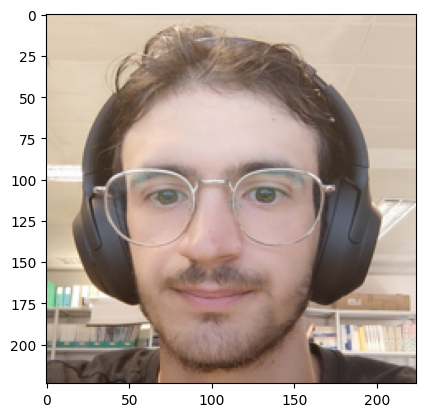

In [52]:
import matplotlib.pyplot as plt

plt.imshow(img[0].permute(1, 2, 0)) ;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016293436..1.026313].


Loss: 0.2004951536655426


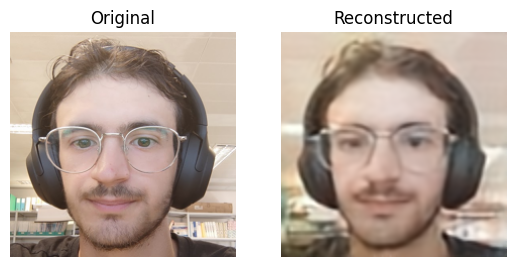

In [53]:

ae.eval()
test1 = ae(img) ;


fig,axs = plt.subplots(1,2) ; 
axs[0].imshow(img[0].detach().cpu().permute(1,2,0))
axs[0].set_title("Original")
axs[0].axis("off")
axs[1].imshow(test1[0].detach().cpu().permute(1,2,0))
axs[1].set_title("Reconstructed")
axs[1].axis("off")

loss = mse(test1, img) + (1 - ssim(test1, img))
print(f"Loss: {loss.item()}")

In [54]:
# https://github.com/CompVis/latent-diffusion

In [55]:
class demorpher(nn.Module):
    def __init__(self, autoencoder, diffusion, noise_steps, noise_start, noise_end):
        super(self).__init__()
        self.encoder = autoencoder

        self.noise_steps = noise_steps

        self.noise_schedule = NoiseScheduler(noise_start, noise_end, noise_steps)
        self.latent_unet = diffusion
        

    def forward(self, img_A, img_ID):

        z_a = self.encoder(img_A)
        z_id = self.encoder(img_ID)

        # z_id = self.noise_schedule.add_noise(z_id,z_a, self.noise_steps - 1) # totally noised image (might not be necessary, i already have z_a!)

        z_out = self.latent_unet.forward(z_id, self.noise_steps - 1)
        # branch A: denoising ...
        for t in reversed(range(self.noise_steps) - 2): #one step is already done
            noise_pred = self.latent_unet.forward(z_out, t) 
        
        # branch B: image reconstruction
        z_out = self.decoder(z_out)

        return z_out

    def get_unet(self):
        return self.latent_unet

    def get_decoder(self):
        return self.decoder
    
    def freeze_unet(self, Freeze = True):
        for param in self.latent_unet.parameters():
            param.requires_grad = not Freeze

In [56]:
if STARTING_CHECKPOINT is not None and STARTING_CHECKPOINT > 0:
    autoencoder.load_state_dict(torch.load(os.path.join(OUTPUT_PATH, f"demorph_{STARTING_CHECKPOINT}.pth")))
    print(f"Loaded model from checkpoint {OUTPUT_PATH}/demorph_{STARTING_CHECKPOINT}.pth")

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

Using device: cuda


In [58]:
class FacesDataset(Dataset):
    r"""
    Dataset class to load the Bonafide images. 
    """
    def __init__(self, bonafide_path, morphed_path, im_ext='png'):
        r"""
        Init method for initializing the dataset properties
        :param split: train/test to locate the image files
        :param im_path: root folder of images
        :param im_ext: image extension. assumes all
        images would be this type.
        """
        self.im_ext = im_ext
        self.bona_fide = self.load_bonafide(bonafide_path)
        self.morphs = self.load_morphs(morphed_path)

    
    def load_bonafide(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        :param im_path:
        :return:
        """
        identities = {}
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        
        for p in os.listdir(im_path):
            for i in os.listdir(os.path.join(im_path, p)):
                id = i.split('.')[0] # getting only the number ...
                id = int(id)

                if id not in identities:
                    identities[id] = {}
                identities[id][p] = os.path.join(im_path, p, i)

        print('Found {} identities.'.format(len(identities)))
        return identities
    
    def load_morphs(self, im_path):
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)

        out = []
        for i in os.listdir(im_path): # list of identities 
            for m in os.listdir(os.path.join(im_path, i)): # morphs
                out.append({"morph" : os.path.join(im_path, i, m),
                            "A" : i,
                            "B" : m.split('_')[1].split('.')[0]})

        return out
    
    def __len__(self):
        return len(self.morphs)
    
    def __getitem__(self, index):
        type = "neutral"
    
        #print("ASKING FOR ITEM:", index, type)
        item = self.morphs[index]

        #print(item)
        morph = Image.open(item["morph"])
        morph = torchvision.transforms.ToTensor()(morph)

        A = int(item["A"])
        im_A = Image.open(self.bona_fide[A][type])  
        im_A = torchvision.transforms.ToTensor()(im_A)

        B = int(item["B"])
        im_B = Image.open(self.bona_fide[B][type])  
        im_B = torchvision.transforms.ToTensor()(im_B)
        # Convert input to -1 to 1 range.
        #im_tensor = (2 * im_tensor) - 1
        return im_A, morph, im_B

Found 1269 identities.


(-0.5, 223.5, 223.5, -0.5)

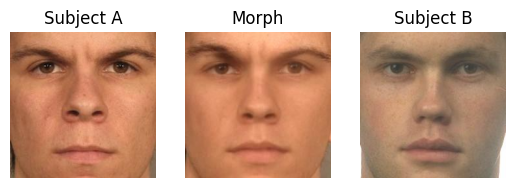

In [59]:
dataset = FacesDataset(BONAFIDE_PATH, MORPHS_PATH)

test = dataset[1]

fig,axs = plt.subplots(1,3) ; 
axs[0].imshow(test[0].detach().cpu().permute(1,2,0))
axs[0].set_title("Subject A")
axs[0].axis("off")
axs[1].imshow(test[1].detach().cpu().permute(1,2,0))
axs[1].set_title("Morph")
axs[1].axis("off")
axs[2].imshow(test[2].detach().cpu().permute(1,2,0))
axs[2].set_title("Subject B")
axs[2].axis("off")


In [60]:
diffusion_model = unet(1).to(device)

def train_diffusion(model, train_ds, device, ae ):
    
    model.train()

    ae.eval()
    ae = ae.to(device)
    for param in ae.parameters():
        param.requires_grad = False

    # Create the noise scheduler
    scheduler = NoiseScheduler( noise_start=0.01,
                                noise_end=0.1,
                                steps=STEPS)
    scheduler.to(device)
    epoch_losses = []

    mse = nn.MSELoss().to(device)

    learning_rate = LEARNING_RATE
    # Specify training parameters
    optimizer = Adam(model.parameters(), lr=learning_rate)
    lrschedule = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

    last_epoch_change = 0


    if not os.path.exists(OUTPUT_PATH):
        os.mkdir(OUTPUT_PATH)


    for epoch_idx in range(EPOCHS):
        losses = []
        if device.type == 'cuda':
             torch.cuda.empty_cache()
        for im_a,im_id,_ in tqdm(train_ds):

            optimizer.zero_grad()
            im_a = im_a.float().to(device)
            im_id = im_id.float().to(device)

            with torch.no_grad():            
                latent_a = ae.get_embeddings(im_a) # * time noise (?)
                latent_id = ae.get_embeddings(im_id)

            t = torch.randint(0, STEPS, (latent_a.shape[0],)).to(device)
            #print(t)
            # print(latent_a.shape)
            # Add noise to images according to timestep (forse no)

            noise_t = scheduler.get_noise(t).view(-1,1)
            Z_a = latent_a * noise_t
            
            z_a_TARGET = Z_a * NOISE_COEFFICIENT

            # i want to multiply z_a with the scalar noise coefficient ...

            
            Z_out_t = latent_id + Z_a


            Z_out_t = torch.reshape(Z_out_t, (Z_out_t.shape[0], 1, 56, 56))
            z_a_TARGET = torch.reshape(z_a_TARGET, (z_a_TARGET.shape[0], 1, 56, 56))
            
            # branch A: denoising ...
            noise_pred = model(Z_out_t, t)

            loss = mse(noise_pred, z_a_TARGET)

            losses.append((loss.item()))
            loss.backward()
            optimizer.step()
        
        # check last three epochs loss, if the optimizer is not converging, decrease the learning rate ... 
        if ((epoch_idx - last_epoch_change > 2) and increasingLoss(losses) and learning_rate > 0.001 ):

            # decrease learning rate by factor of 2 ...
            learning_rate = learning_rate * 0.5

            optimizer = Adam(model.parameters(), lr=learning_rate)
            # learning rate scheduler to decrease it gradually ...
            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
            last_epoch_change = epoch_idx

        else:
            lrschedule.step()
        
        epoch_losses.append(np.mean(losses))



        result = ('Finished epoch:{} | Loss : {:.5f} | Learning Rate: {} '.format(
            STARTING_CHECKPOINT + epoch_idx + 1,
            np.mean(epoch_losses),
            learning_rate,
        ))

        print(result)
        with open(os.path.join(OUTPUT_PATH, 'losses.txt'), 'a') as f:
            f.write(result + '\n')
        if (epoch_idx + 1) % 5 == 0 or epoch_idx == EPOCHS - 1:
            send_webHook(URL, result) 
            torch.save(model.state_dict(), os.path.join(OUTPUT_PATH,
                                                    "diffusion_{}.pth".format(STARTING_CHECKPOINT + epoch_idx + 1)))

    print('Finished Training')

    return epoch_losses

In [61]:

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_ds, _ = torch.utils.data.random_split(dataset, [train_size, test_size])
starting_message = f"\nStarting training with {len(train_ds)} training samples.\n~~ Parameters ~~\nBatch size: {BATCH_SIZE}\nEpochs: {EPOCHS}\nDevice: {device}\n"
send_webHook(URL, starting_message)
print(starting_message)
del starting_message

OK

Starting training with 447440 training samples.
~~ Parameters ~~
Batch size: 8
Epochs: 100
Device: cuda



In [62]:
train_ds = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [64]:
try:
    train_diffusion(diffusion_model, train_ds, device, ae)
    send_webHook(URL, "Training completed")
except Exception as e:
    send_webHook(URL, f"Error during training: {str(e)}")

  0%|          | 0/55930 [00:00<?, ?it/s]

  0%|          | 1/55930 [00:00<5:31:30,  2.81it/s]

torch.Size([8, 3136])


  0%|          | 2/55930 [00:00<5:35:50,  2.78it/s]

torch.Size([8, 3136])


  0%|          | 2/55930 [00:00<6:32:26,  2.38it/s]


KeyboardInterrupt: 

: 